# Import Libraries

In [92]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage.filters import threshold_multiotsu
from skimage.morphology import remove_small_objects, remove_small_holes, disk, binary_opening, binary_closing, skeletonize
from skimage.measure import label
from scipy.ndimage import distance_transform_edt, binary_fill_holes
from skimage import img_as_ubyte

# Helper Functions

In [93]:
def show_images(test_cases, titles=None):
    """Display images in a 2x3 grid"""
    num_cases = len(test_cases)
    rows = (num_cases + 2) // 3  # Calculate rows needed
    cols = min(3, num_cases)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)
    
    axes = axes.flatten()
    
    for idx, img in enumerate(test_cases):
        if len(img.shape) == 2:  # Grayscale
            axes[idx].imshow(img, cmap='gray')
        else:  # Color
            axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        title = titles[idx] if titles else f"Case {idx + 1}"
        axes[idx].set_title(title)
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(num_cases, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


def show_images_cropped(test_cases, titles=None, slice_size_px=None, col_width=5):
    """Display cropped images in a grid with figure height adjusted to avoid whitespace.
    
    Parameters
    ----------
    test_cases : list of np.ndarray
        List of images to display.
    titles : list of str, optional
        Titles for each image.
    slice_size_px : int, optional
        The height in pixels of the cropped images. If None, uses the height
        of the first image in test_cases.
    col_width : float, optional
        Width in inches for each column (default 5).
    """
    if len(test_cases) == 0:
        return
    
    num_cases = len(test_cases)
    rows = (num_cases + 2) // 3  # Calculate rows needed
    cols = min(3, num_cases)
    
    # Determine image dimensions
    if slice_size_px is None:
        slice_size_px = test_cases[0].shape[0]
    
    # Get image width (assume all images have same width)
    img_width = test_cases[0].shape[1]
    
    # Calculate aspect ratio of cropped images
    aspect_ratio = slice_size_px / img_width if img_width > 0 else 1.0
    
    # Calculate figure dimensions
    fig_width = col_width * cols
    row_height = col_width * aspect_ratio  # Scale height by aspect ratio
    fig_height = row_height * rows + 0.5 * rows  # Add small padding for titles
    
    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)
    
    axes = axes.flatten()
    
    for idx, img in enumerate(test_cases):
        if len(img.shape) == 2:  # Grayscale
            axes[idx].imshow(img, cmap='gray', aspect='equal')
        else:  # Color
            axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), aspect='equal')
        
        title = titles[idx] if titles else f"Case {idx + 1}"
        axes[idx].set_title(title)
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(num_cases, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


def show_histograms(images, titles=None, bins=256):
    """Display histograms for a list of images in a 2x3-like grid (up to 3 columns)."""
    num = len(images)
    rows = (num + 2) // 3
    cols = min(3, num)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.reshape(rows, cols)
    axes = axes.flatten()

    for idx, im in enumerate(images):
        ax = axes[idx]
        if im.ndim == 2:  # grayscale
            ax.hist(im.ravel(), bins=bins, color='k')
            ax.set_ylabel('Count')
        else:  # color (BGR from cv2)
            colors = ('b', 'g', 'r')
            for c_idx, c in enumerate(colors):
                ax.hist(im[..., c_idx].ravel(), bins=bins, color=c, alpha=0.6, label=c)
            ax.legend(title='Channel')
            ax.set_ylabel('Count')

        ax.set_xlim(0, 255)
        ax.set_xlabel('Pixel value')
        title = (titles[idx] if titles else f"Case {idx+1}")
        ax.set_title(title)

    # Hide unused axes
    for j in range(num, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_case_stats(means, stds=None, titles=None, rows=2, cols=3, figsize=(12, 6), ylabel="Diameter (µm)"):
    """Plot per-case mean ± std in a rows x cols grid.

    Parameters
    - means: sequence of mean values (can contain np.nan)
    - stds: sequence of std values (same length as means) or None
    - titles: optional list of titles for each subplot
    - rows, cols: grid layout
    """
    import numpy as _np
    import matplotlib.pyplot as _plt

    n = len(means)
    fig, axes = _plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    # Determine y-limit from valid means
    valid_means = [m for m in means if not _np.isnan(m)]
    max_mean = max(valid_means) if valid_means else 1.0

    for idx in range(rows * cols):
        ax = axes[idx]
        if idx < n:
            m = means[idx]
            sd = stds[idx] if (stds is not None and idx < len(stds)) else 0
            title = titles[idx] if (titles is not None and idx < len(titles)) else f"Case {idx+1}"

            if _np.isnan(m):
                ax.text(0.5, 0.5, "No data", ha='center', va='center', fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.bar(0, m, yerr=sd, capsize=5, color='C0')
                ax.set_xlim(-0.5, 0.5)
                ax.set_ylim(0, max_mean * 1.2)
                ax.set_xticks([])
                ax.set_ylabel(ylabel)
                ax.set_title(f"{title}\nmean={m:.1f} µm\nstd={sd:.1f} µm")
        else:
            ax.axis('off')

    _plt.tight_layout()
    _plt.show()

def diameter_profile(mask_bin, um_per_px):
    """
    mask_bin: cleaned binary mask (0/1)
    returns: diameters in micrometers along the silk
    """
    # Distance transform on foreground
    dist = distance_transform_edt(mask_bin)

    # Skeleton
    skel = skeletonize(mask_bin.astype(bool))

    # Distances on skeleton → radius
    radii_px = dist[skel]
    diam_px = 2.0 * radii_px
    diam_um = diam_px * um_per_px
    return diam_um

def enforce_two_bg_one_silk(core):
    """
    Enforce exactly two background regions and one connected silk region.

    Inputs
    ------
    core : np.ndarray (bool or 0/1)
        Foreground mask from 2-class Otsu:
            True/1  -> silk candidate
            False/0 -> background

    Returns
    -------
    final_silk_uint8 : np.ndarray (0/1 uint8)
        Final solid silk region (single connected component, no holes).
    final_bg_uint8 : np.ndarray (0/1 uint8)
        Final background mask = union of two background regions.
    (n_bg_final, n_silk_final) : tuple of ints
        Number of connected components in final_bg and final_silk (diagnostics).
    """

    band_raw = core.astype(bool)
    bg_orig = ~band_raw

    def sorted_components(mask_bool):
        lbl = label(mask_bool)
        comps = []
        for lab in range(1, lbl.max() + 1):
            comp = (lbl == lab)
            comps.append((int(comp.sum()), comp))
        comps.sort(key=lambda x: x[0], reverse=True)
        return comps

    # 1) Two background regions
    areas_o = sorted_components(bg_orig)
    if len(areas_o) >= 2:
        bg1 = areas_o[0][1].copy()
        bg2 = areas_o[1][1].copy()
        final_bg = bg1 | bg2
    else:
        bg = bg_orig.copy()
        radius = 1
        max_radius = max(bg.shape) // 4

        while True:
            comps = sorted_components(bg)
            if len(comps) >= 2:
                bg1 = comps[0][1].copy()
                bg2 = comps[1][1].copy()
                final_bg = bg1 | bg2
                break

            if radius > max_radius:
                # last resort: split left/right
                h, w = bg.shape
                mid = w // 2
                bg1 = np.zeros_like(bg, dtype=bool)
                bg2 = np.zeros_like(bg, dtype=bool)
                bg1[:, :mid] = True
                bg2[:, mid:] = True
                final_bg = bg1 | bg2
                break

            bg = binary_closing(bg, disk(radius))
            bg = binary_fill_holes(bg)
            radius += 1

    # 2) Silk = complement of chosen background, filled
    final_silk = ~final_bg
    final_silk = binary_fill_holes(final_silk)

    # 3) Ensure silk is a single component: keep largest silk, reassign the rest to nearest bg
    lbl_silk = label(final_silk)
    if lbl_silk.max() > 1:
        silk_comps = sorted_components(final_silk)
        main_silk = silk_comps[0][1].copy()
        other_silk = np.zeros_like(final_silk, dtype=bool)
        for _, comp in silk_comps[1:]:
            other_silk |= comp

        dist_bg1 = distance_transform_edt(~bg1)
        dist_bg2 = distance_transform_edt(~bg2)

        assign_to_bg1 = (dist_bg1 < dist_bg2) & other_silk
        assign_to_bg2 = (dist_bg2 <= dist_bg1) & other_silk

        bg1 |= assign_to_bg1
        bg2 |= assign_to_bg2

        final_bg = bg1 | bg2
        final_silk = ~final_bg
        final_silk = binary_fill_holes(final_silk)

    # 4) Safety fallback
    if final_silk.sum() == 0:
        final_silk = binary_fill_holes(band_raw)
        if final_silk.sum() == 0:
            final_silk = band_raw

    n_bg_final = label(final_bg).max()
    n_silk_final = label(final_silk).max()

    return final_silk.astype(np.uint8), final_bg.astype(np.uint8), (n_bg_final, n_silk_final)

def compute_skeleton(mask, method='centerline', smooth_window=11, width=1, closing_height=3):
    """Compute a 1-pixel-wide skeleton for a binary mask.

    Parameters
    - mask: 2D array-like (0/1 or bool)
    - method: 'skeletonize' to use skimage.skeletonize, or 'centerline' to compute
              a single-pixel-per-row centerline then skeletonize it.
    - smooth_window: integer odd window for smoothing the per-row center x coordinates
    - width: if >1, widen the centerline horizontally before skeletonizing
    - closing_height: vertical closing size to fill tiny gaps in the line

    Returns
    - boolean array same shape as mask containing the skeleton
    """
    m = mask.astype(bool)
    if method == 'skeletonize':
        return skeletonize(m).astype(bool)

    # centerline method
    h, w = m.shape
    xs = np.full(h, np.nan)
    for y in range(h):
        cols = np.nonzero(m[y, :])[0]
        if cols.size:
            xs[y] = np.median(cols)

    # If no rows contained silk, return empty skeleton
    if not np.isfinite(xs).any():
        return np.zeros_like(m, dtype=bool)

    # Interpolate missing rows
    rows = np.arange(h)
    good = np.isfinite(xs)
    if not good.all():
        xs[~good] = np.interp(rows[~good], rows[good], xs[good])

    # Smooth x positions with a simple moving average
    if smooth_window is None or smooth_window <= 1:
        xs_smooth = xs
    else:
        k = np.ones(smooth_window) / float(smooth_window)
        xs_smooth = np.convolve(xs, k, mode='same')

    xs_int = np.clip(np.round(xs_smooth).astype(int), 0, w - 1)

    line = np.zeros((h, w), dtype=bool)
    line[rows, xs_int] = True

    # Fill tiny vertical gaps with a narrow vertical closing
    try:
        from skimage.morphology import binary_closing, rectangle, dilation
        line = binary_closing(line, rectangle(closing_height, 1))
    except Exception:
        # fallback: simple interpolation of isolated missing rows
        for y in range(1, h - 1):
            if not line[y].any() and line[y - 1].any() and line[y + 1].any():
                cx_prev = int(np.round(np.nonzero(line[y - 1])[0].mean()))
                cx_next = int(np.round(np.nonzero(line[y + 1])[0].mean()))
                cx = int(np.round((cx_prev + cx_next) / 2.0))
                if 0 <= cx < w:
                    line[y, cx] = True

    # Optionally widen before skeletonizing
    if width is not None and width > 1:
        try:
            from skimage.morphology import dilation, rectangle
            line = dilation(line, rectangle(1, width))
        except Exception:
            pad = width // 2
            new = np.zeros_like(line)
            for y in range(h):
                x = xs_int[y]
                l = max(0, x - pad)
                r = min(w, x + pad + 1)
                new[y, l:r] = True
            line = new

    # Final skeletonize to ensure a 1-pixel-wide center
    sk = skeletonize(line)
    return sk.astype(bool)


def diameters_from_skeleton(skeleton, dist_map, um_per_px):
    """
    Compute local diameters along a 1-pixel-wide skeleton using
    a Euclidean distance transform.

    Parameters
    ----------
    skeleton : 2D np.ndarray of bool or 0/1
        Skeleton mask: True/1 on the centreline, False/0 elsewhere.
    dist_map : 2D np.ndarray of float
        Euclidean distance transform of the *same* binary mask
        used to create the skeleton. Each pixel = distance [px]
        to nearest background.
    um_per_px : float, optional
        Scale factor to convert pixels to micrometres.

    Returns
    -------
    diam_px : 1D np.ndarray
        Local diameters in pixels at each skeleton pixel.
    diam_um : 1D np.ndarray
        Same diameters in micrometres.
    stats : dict
        Summary statistics (mean, std, min, max in µm).
    """

    # Ensure boolean skeleton
    skel_bool = skeleton.astype(bool)

    # Radii at skeleton pixels (in pixels)
    radii_px = dist_map[skel_bool]

    # Filter out zeros just in case (edge artefacts)
    radii_px = radii_px[radii_px > 0]

    diam_px = 2.0 * radii_px
    diam_um = diam_px * um_per_px

    stats = {
        "mean_um": float(diam_um.mean()) if diam_um.size else np.nan,
        "std_um":  float(diam_um.std())  if diam_um.size else np.nan,
        "min_um":  float(diam_um.min())  if diam_um.size else np.nan,
        "max_um":  float(diam_um.max())  if diam_um.size else np.nan,
        "n_points": int(diam_um.size),
    }

    return diam_px, diam_um, stats
def analyze_purity(regions):
    """
    regions : 2D array, with labels
        0 -> pure
        1 -> uncertainty
        (others ignored)

    Returns:
        dict with percentages:
        {
            'pure_pct', 'unc_pct', 'pure_plus_unc_pct'
        }
    """
    regs = np.asarray(regions)

    pure_px = int((regs == 0).sum())
    unc_px  = int((regs == 1).sum())
    total_px = pure_px + unc_px

    if total_px == 0:
        return {
            "pure_pct": 0.0,
            "unc_pct": 0.0,
            "pure_plus_unc_pct": 0.0,
        }

    pure_pct = 100.0 * pure_px / total_px
    unc_pct  = 100.0 * unc_px  / total_px

    return {
        "pure_pct": pure_pct,
        "unc_pct":  unc_pct,
        "pure_plus_unc_pct": pure_pct + unc_pct,  # ~100%
    }


def plot_purity_bars(purity_results, titles=None):
    """
    purity_results : list of dicts returned by analyze_purity
                    (expects keys 'pure_pct', 'unc_pct')
    titles         : list of strings, one per case
    """
    n = len(purity_results)
    if titles is None:
        titles = [f"Case {i+1}" for i in range(n)]

    # Layout: up to 3 columns, enough rows
    n_cols = min(3, n)
    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = np.array([axes])
    elif n_cols == 1:
        axes = np.array([[ax] for ax in axes])

    axes_flat = axes.ravel()

    for idx, (res, title) in enumerate(zip(purity_results, titles)):
        ax = axes_flat[idx]

        pure = res.get("pure_pct", 0.0)
        unc  = res.get("unc_pct", 0.0)

        # Single stacked bar at x=0
        x = 0
        width = 0.6

        ax.bar(x, pure, width, label="pure")
        ax.bar(x, unc,  width, bottom=pure, label="uncertainty")

        ax.set_xlim(-1, 1)
        ax.set_xticks([x])
        ax.set_xticklabels(["silk"])
        ax.set_ylim(0, 100)
        ax.set_ylabel("Percent of silk pixels [%]")
        ax.set_title(title)

    # Hide unused subplots
    for j in range(idx + 1, n_rows * n_cols):
        fig.delaxes(axes_flat[j])

    # Only one legend for the whole figure
    handles, labels = axes_flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    fig.tight_layout()
    plt.show()

# 1. Load images and show histogram

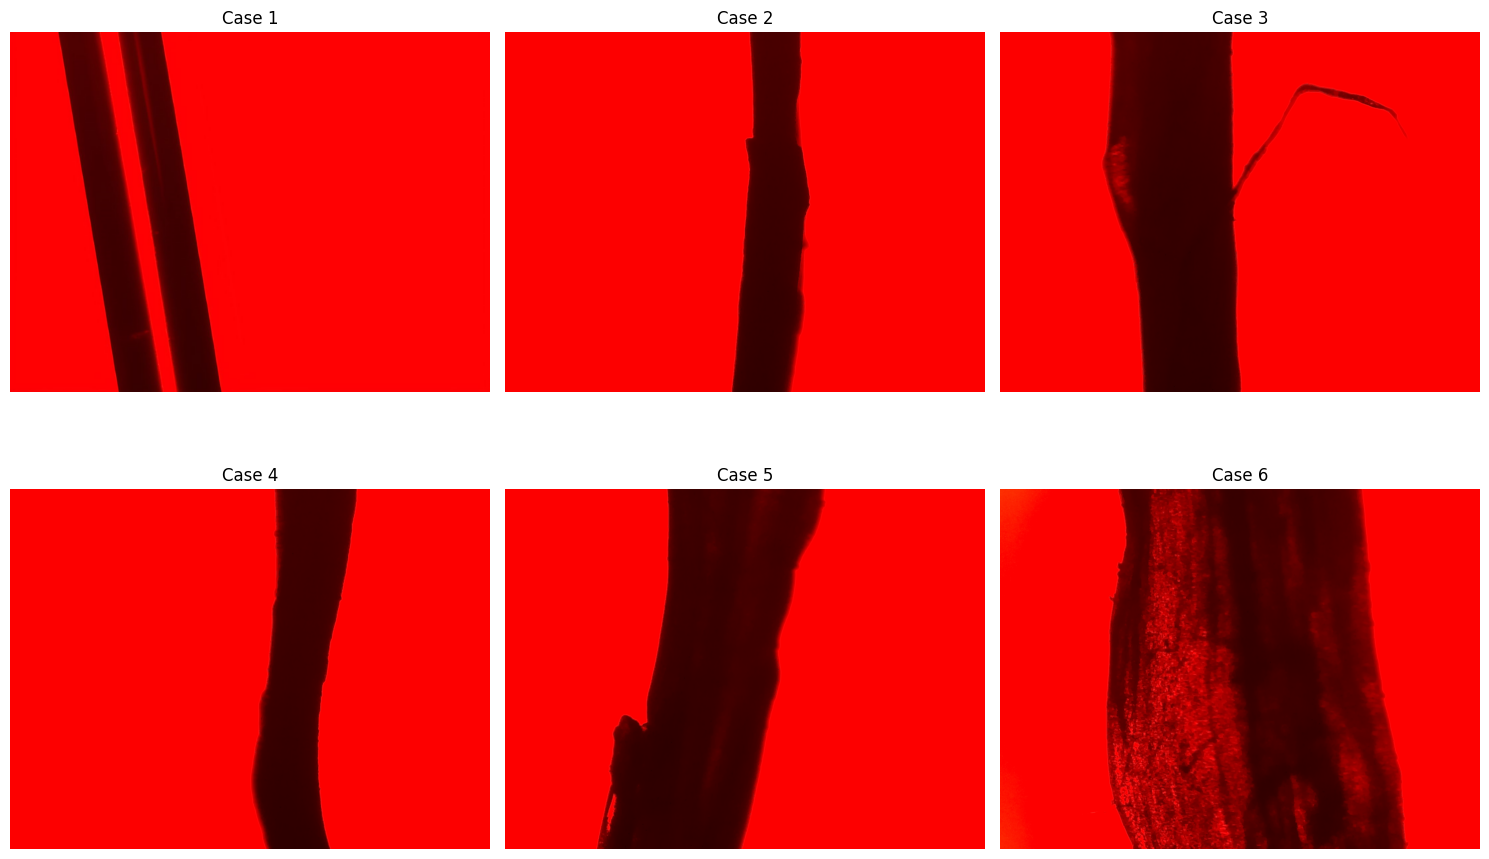

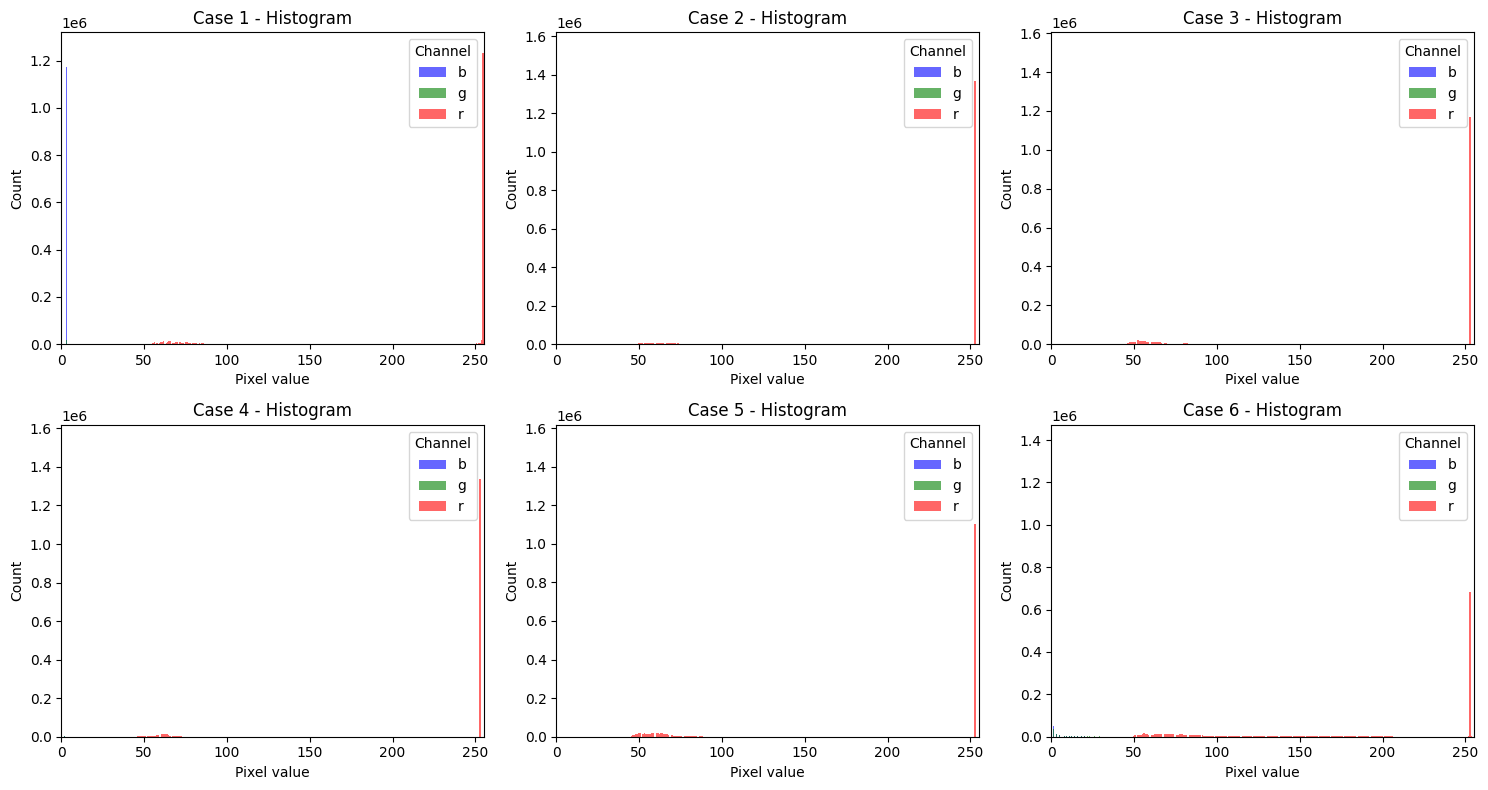

In [94]:
# Load test images using PIL
test_cases = []
for i in range(1, 7):
    img = Image.open(f'{i}.png')
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    test_cases.append(img_cv)

# Display original images
show_images(test_cases, titles=[f"Case {i+1}" for i in range(len(test_cases))])

# Show histograms
show_histograms(test_cases, titles=[f"Case {i+1} - Histogram" for i in range(len(test_cases))])

# 2. Greyscale and Crop

Cropping images to 600 pixels height. The original image height is 1080 pixels.


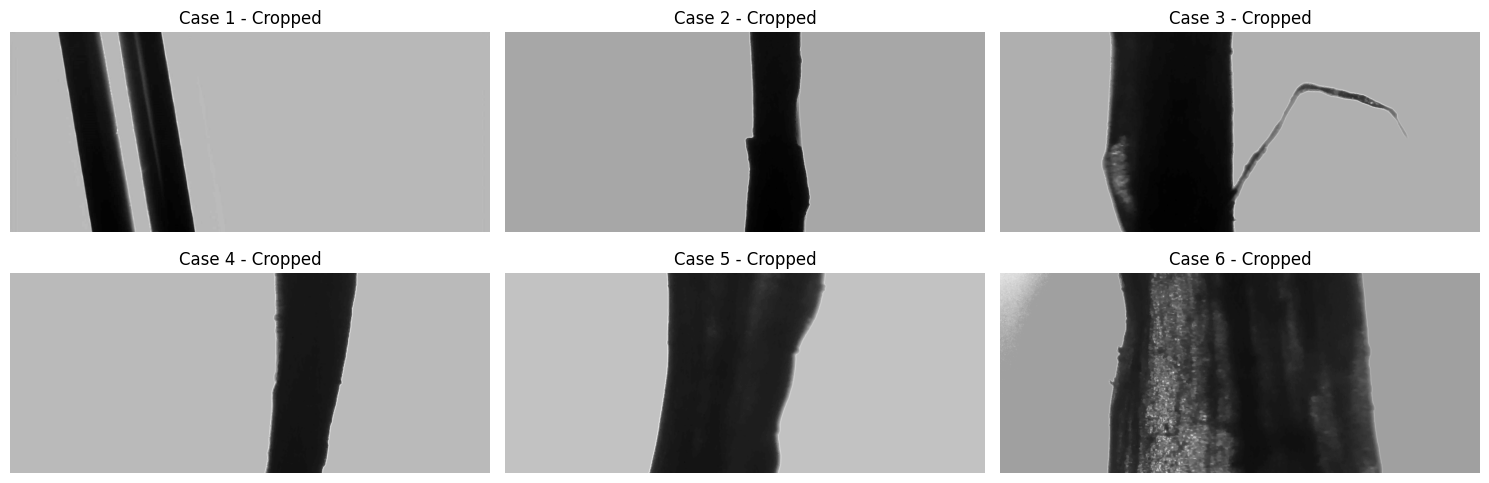

In [95]:
# Crop images to slice_size_px height, keeping full width
slice_size_mm = 0.5;
um_per_px = 1.2;  # Example conversion factor, adjust as needed
slice_size_px = int(slice_size_mm * 1000 * um_per_px);
print(f"Cropping images to {slice_size_px} pixels height. The original image height is {test_cases[0].shape[0]} pixels.")

test_cases_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in test_cases]
test_cases_gray_cropped = [img[:slice_size_px, :] for img in test_cases_gray]
show_images_cropped(test_cases_gray_cropped, titles=[f"Case {i+1} - Cropped" for i in range(len(test_cases_gray_cropped))])

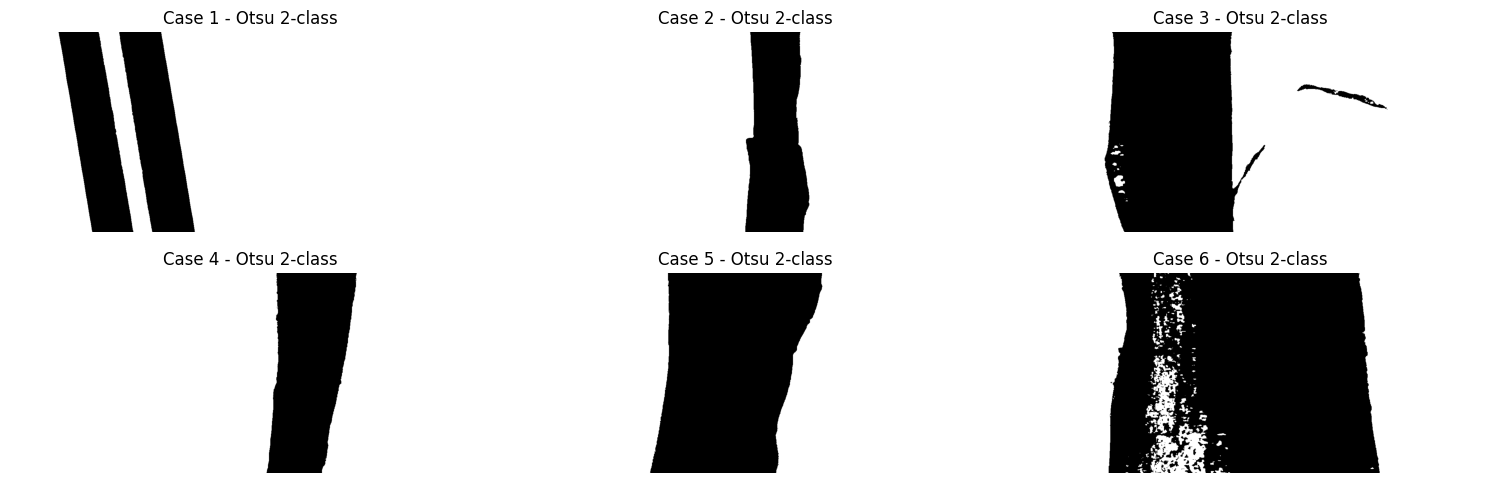

In [96]:
# Apply Otsu to cropped grayscale images
test_cases_otsu_bg_and_silk = []
for img in test_cases_gray_cropped:
    thresholds = threshold_multiotsu(img, classes=2)
    regions = np.digitize(img, bins=thresholds)
    test_cases_otsu_bg_and_silk.append(regions)

show_images_cropped(test_cases_otsu_bg_and_silk, titles=[f"Case {i+1} - Otsu 2-class" for i in range(len(test_cases_otsu_bg_and_silk))])

# 3. Example Segment

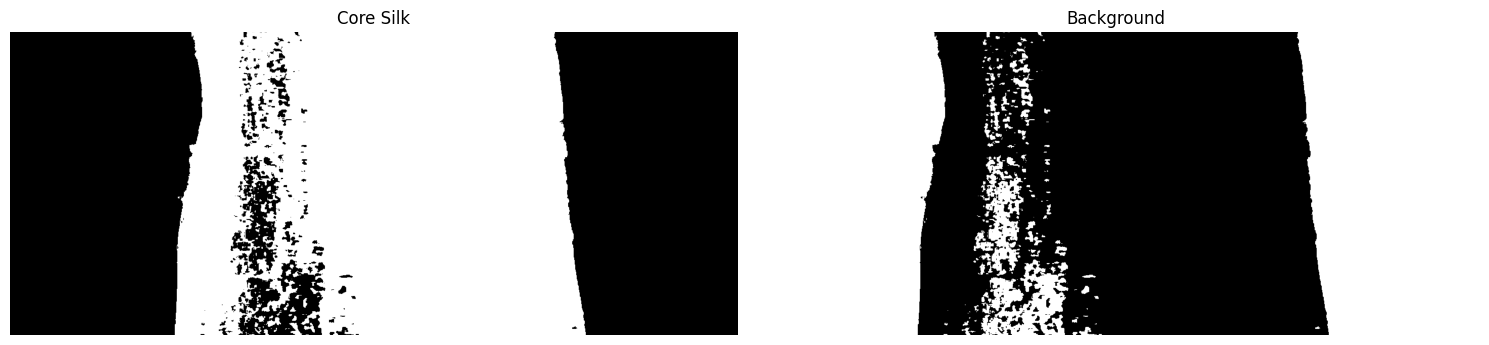

In [97]:
core = (regions == 0)       # sure silk
background = (regions == 1)       # background
show_images([core, background],
            titles=["Core Silk", "Background"])

# 4. Fill the small holes, to measure properly the diameter

Final background components: 2, Final silk components: 1


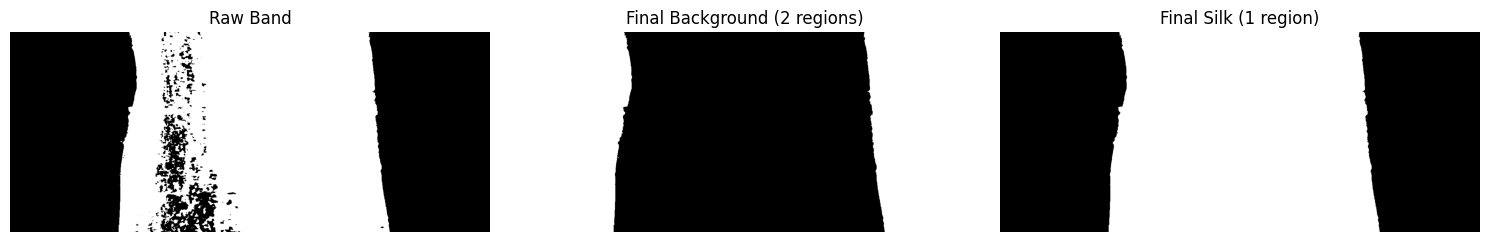

In [98]:
# Request a single somewhat-vertical center line for the silk
final_silk, final_bg, (n_bg_final, n_silk_final) = enforce_two_bg_one_silk(core)
print(f"Final background components: {n_bg_final}, Final silk components: {n_silk_final}")

show_images_cropped([core, final_bg.astype(np.uint8), final_silk.astype(np.uint8)],
            titles=["Raw Band", "Final Background (2 regions)", "Final Silk (1 region)"])

# Update band variable used later
band = final_silk.astype(bool)

# 5. Show the band for all of the pictures.

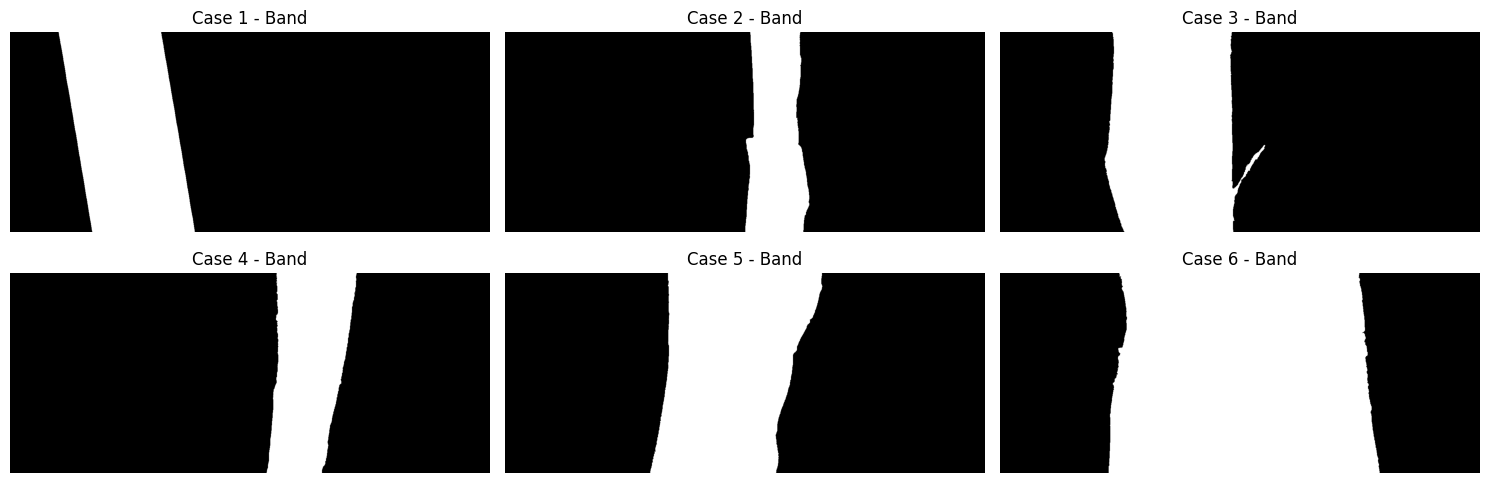

In [99]:
test_cases_band = []
test_cases_core = []
for img in test_cases_otsu_bg_and_silk:
    core = (img == 0)       # sure silk
    background   = (img == 1)       # background
    final_silk, final_bg, (n_bg_final, n_silk_final) = enforce_two_bg_one_silk(core)
    test_cases_band.append(final_silk)
    test_cases_core.append(core)

show_images_cropped(test_cases_band, titles=[f"Case {i+1} - Band" for i in range(len(test_cases_otsu_bg_and_silk))])

# 6. Skeletonize

C:\Users\Artis\AppData\Local\Temp\ipykernel_20016\2124495583.py:349: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  line = binary_closing(line, rectangle(closing_height, 1))


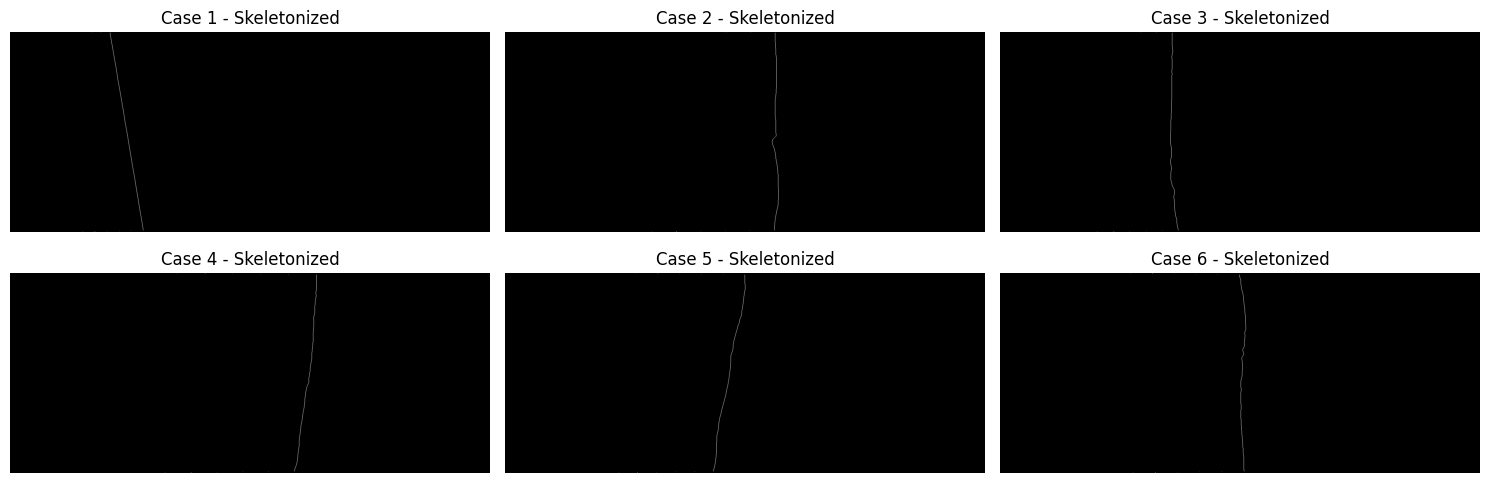

In [100]:
# Apply 3-class Otsu to cropped grayscale images
test_cases_skeletonized = []
for img in test_cases_band:
    skeleton = compute_skeleton(img)
    test_cases_skeletonized.append(skeleton)

show_images_cropped(test_cases_skeletonized, titles=[f"Case {i+1} - Skeletonized" for i in range(len(test_cases_otsu_bg_and_silk))])


# 7. Perform a distance transform

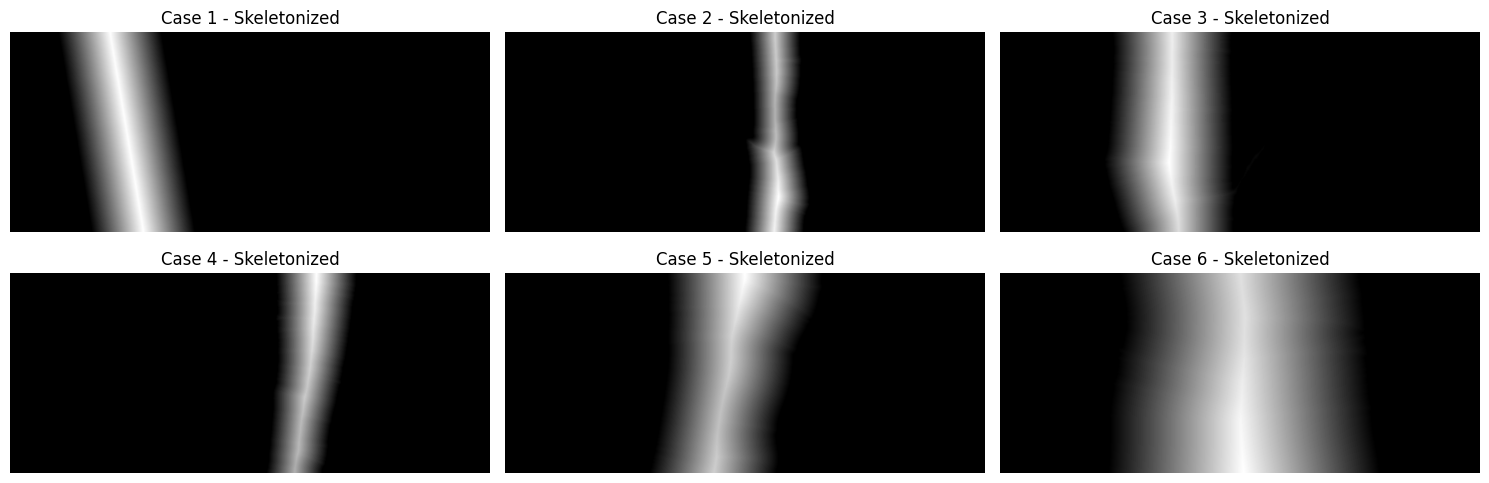

In [101]:
test_cases_dist = []
for img in test_cases_band:
    dist = distance_transform_edt(img)
    test_cases_dist.append(dist)

show_images_cropped(test_cases_dist, titles=[f"Case {i+1} - Skeletonized" for i in range(len(test_cases_otsu_bg_and_silk))])


# 8. Calculate the diameter

Per-case stats:
{'case': 1, 'mean_um': 359.6680605102012, 'std_um': 32.13225776790157, 'n_points': 601}
{'case': 2, 'mean_um': 179.19834350398455, 'std_um': 23.986463728209703, 'n_points': 592}
{'case': 3, 'mean_um': 422.56996277163597, 'std_um': 30.74411363025035, 'n_points': 596}
{'case': 4, 'mean_um': 232.9769857924839, 'std_um': 29.432318772839476, 'n_points': 592}
{'case': 5, 'mean_um': 443.78728056694587, 'std_um': 43.91914714779294, 'n_points': 596}
{'case': 6, 'mean_um': 879.0748496855276, 'std_um': 84.51658438288419, 'n_points': 602}


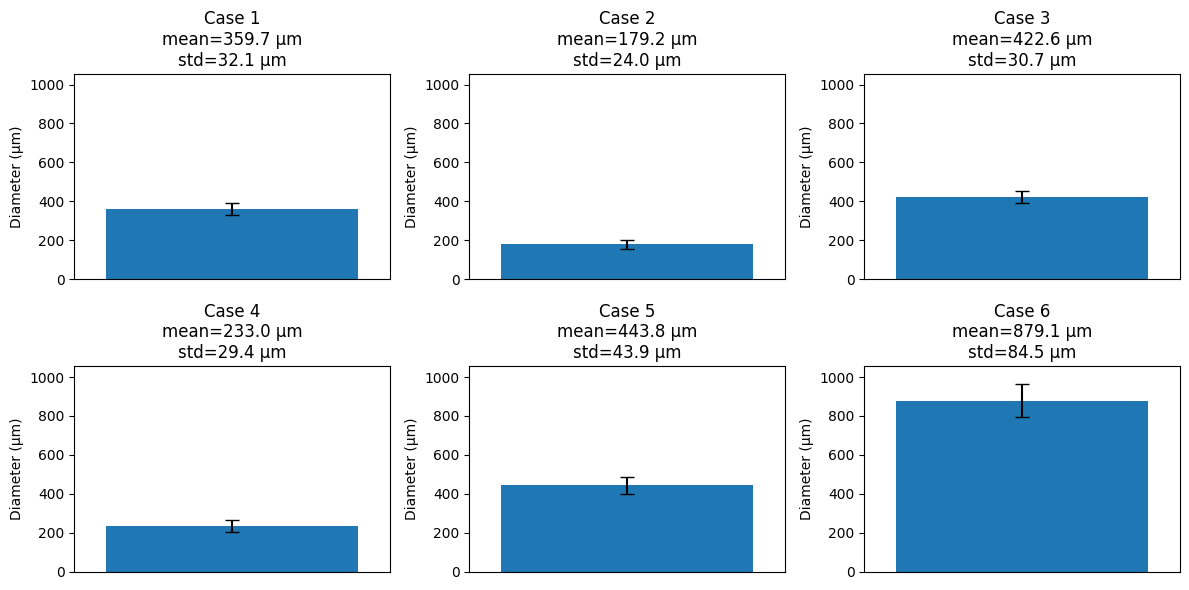

In [102]:
means = []
stds = []
n_points = []

for i, (skel, dist) in enumerate(zip(test_cases_skeletonized, test_cases_dist)):
    diam_px, diam_um, stats = diameters_from_skeleton(skel, dist, um_per_px)
    means.append(stats["mean_um"])
    stds.append(stats["std_um"])
    n_points.append(stats["n_points"])

# Build a summary list of dicts
test_cases_stats = [
    {"case": i + 1, "mean_um": float(m) if not np.isnan(m) else np.nan, "std_um": float(s) if not np.isnan(s) else np.nan, "n_points": int(n)}
    for i, (m, s, n) in enumerate(zip(means, stds, n_points))
]

print("Per-case stats:")
for s in test_cases_stats:
    print(s)

# Plot using the reusable helper (keeps data collection separate)
plot_case_stats(means, stds, titles=[f"Case {i+1}" for i in range(len(means))])



# 9. Purity

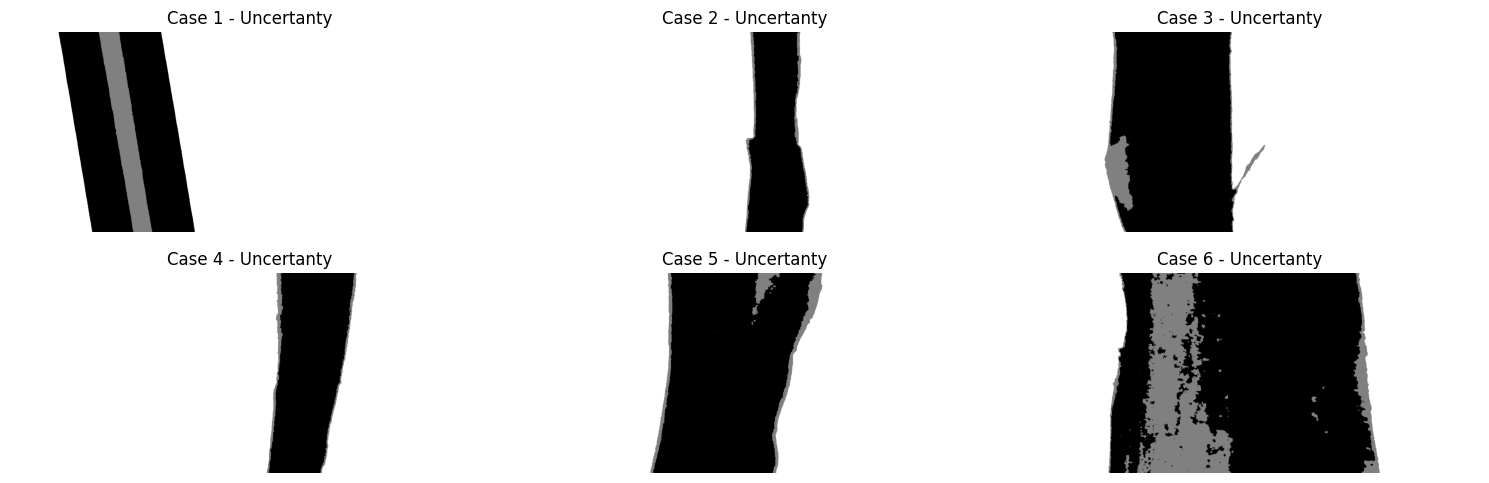

In [103]:
test_cases_pure        = []
test_cases_uncertainty = []
test_cases_background  = []
test_cases_regions     = []   # 0 = pure, 1 = uncertainty, 2 = background

for core, band, gray in zip(test_cases_core, test_cases_band, test_cases_gray_cropped):
    """
    core_bool = core.astype(bool)       # raw 2-class Otsu silk
    band_bool = band.astype(bool)       # filled silk (enforced 2 bg + 1 silk)

    # I want to perform another otsu, but only on the band region, and see how it will be split into core and uncertainty
    
    unc_and_pure = band_bool & gray

    pure_unc_thresholds = threshold_multiotsu(, classes=2)
    regions = np.digitize(img, bins=thresholds)
    test_cases_otsu_bg_and_silk.append(regions)

    
    pure = core_bool
    unc  = band_bool & (~core_bool)     # filled but not in raw core
    bg = ~band_bool                   # everything outside filled silk
    """
    band_bool = band.astype(bool)   # filled silk (enforced 2 bg + 1 silk)

    # Make sure gray matches band shape (in case of cropping)
    gray = np.asarray(gray)
    h_b, w_b = band_bool.shape
    gray_use = gray[:h_b, :w_b]

    # Take only gray values inside the band
    band_vals = gray_use[band_bool]

    if band_vals.size == 0 or band_vals.std() < 1e-3:
        # No meaningful variation inside band: treat entire band as pure, no uncertainty
        pure = band_bool.copy()
        unc  = np.zeros_like(band_bool, dtype=bool)
    else:
        # Otsu threshold ONLY on band pixels
        t = threshold_multiotsu(band_vals, classes=2)

        # Silk is darker -> intensities <= t
        pure = band_bool & (gray_use <= t)
        unc  = band_bool & (~pure)
    
    bg   = ~band_bool                   # everything outside filled silk
    
    regions = np.zeros_like(core, dtype=np.uint8)
    regions[pure] = 0
    regions[unc]  = 1
    regions[bg]   = 2

    test_cases_regions.append(regions)
    test_cases_pure.append(pure)
    test_cases_uncertainty.append(unc)
    test_cases_background.append(bg)
    

show_images_cropped(test_cases_regions, titles=[f"Case {i+1} - Uncertanty" for i in range(len(test_cases_otsu_bg_and_silk))])


# 10. Visualize Purity

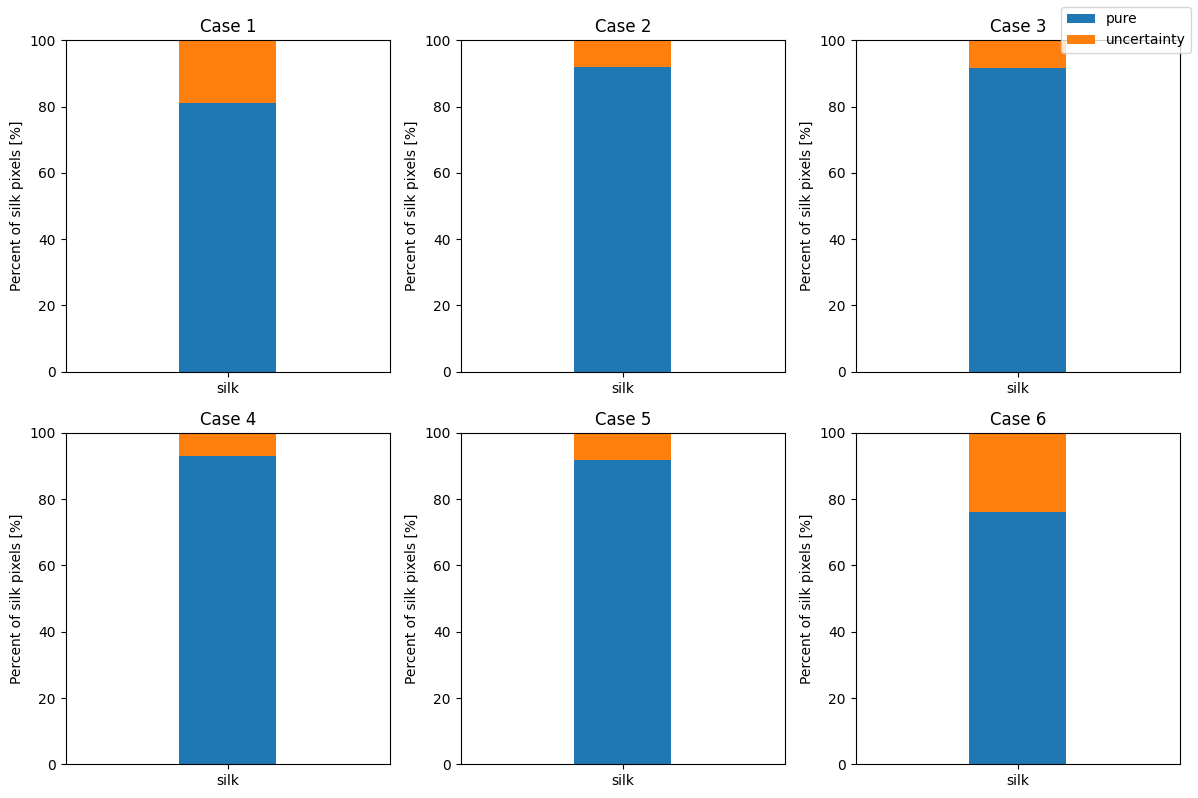

In [104]:
# I want to now use test_cases_regions to analyze purity, but show all 6 in one figure
purity_results = []

for i, regions in enumerate(test_cases_regions):
    result = analyze_purity(test_cases_regions[i])
    purity_results.append(result)
                                  
purity_results = [analyze_purity(reg) for reg in test_cases_regions]
plot_purity_bars(purity_results, titles=[f"Case {i+1}" for i in range(len(purity_results))])